# Introduction to parallel computing with IPython
**_By Shahar Shani-Kadmiel, TU Delft, Aug 2017_**

---


Here are some notes I made following the [IPython for parallel
computing documentation](http://ipyparallel.readthedocs.io/en/latest/index.html).

I installed `ipyparallel` with:

```sh
$ conda install ipyparallel
```

# Starting the IPython controller and engines

Currently I intend to use `ipyparallel` on a single, muli-core local
or a remote machine. In the future I might start distributing **IPython**
code over multi-node (and core) clusters and then I will add more to this
documentation.

For now, starting an `ipcluster` on my local Mac is done like this:

```sh
$ (ipcluster start &)
```

which starts the IPython controller and 8 engines (the maximum
locally available cores). Apparently the parentheses `( )` are
needed.

on the linux cluster, I start `ipcluster` with:

```sh
$ nohup ipcluster start &
```
    
which starts 40 engines (Ameland). ``nohup`` makes sure the engines keep running
if my session gets terminated accidentally. I can always stop the engines
with:

```sh
$ ipcluster stop
```

The controller shares a core with one of the engines (1 engine per core).
You should not start more engines than cores, although it is allowed (
ipcluster will not give you an error or warning...), that will probably mess
things up and oversubscribe your cores resulting in decreased performance.

# Starting the IPython kernel and creating a DirectView instance

In [1]:
from ipyparallel import Client as RC
rc = RC()
dv = rc[:]
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

# Serial vs. Parallel example code:

I will define two functions that do the same computation.
one is going to be a **`serial`** function to be executed on one core.
The other will be a **`parallel`** function to be executed on multiple
cores.

The **`@parallel`** decorator creates parallel functions, that break up
an element-wise operations and distribute them, reconstructing the
result. I will show the difference between a **`blocking`** and a
**`non-blocking`** parallel call.

## Blocking

----------------------------------------------------------
|   n   | serial time | parallel time | ratio | equality |
----------------------------------------------------------
| 1e+01 |   0.00001 s |     0.03162 s | 0.00x |   True   |
| 1e+02 |   0.00005 s |     0.03071 s | 0.00x |   True   |
| 1e+03 |   0.00132 s |     0.02760 s | 0.05x |   True   |
| 1e+04 |   0.01308 s |     0.02798 s | 0.47x |   True   |
| 1e+05 |   0.11632 s |     0.07821 s | 1.49x |   True   |
| 1e+06 |   1.21293 s |     0.67997 s | 1.78x |   True   |
| 1e+07 |  11.41643 s |     6.07682 s | 1.88x |   True   |
------------------------------------------------------------


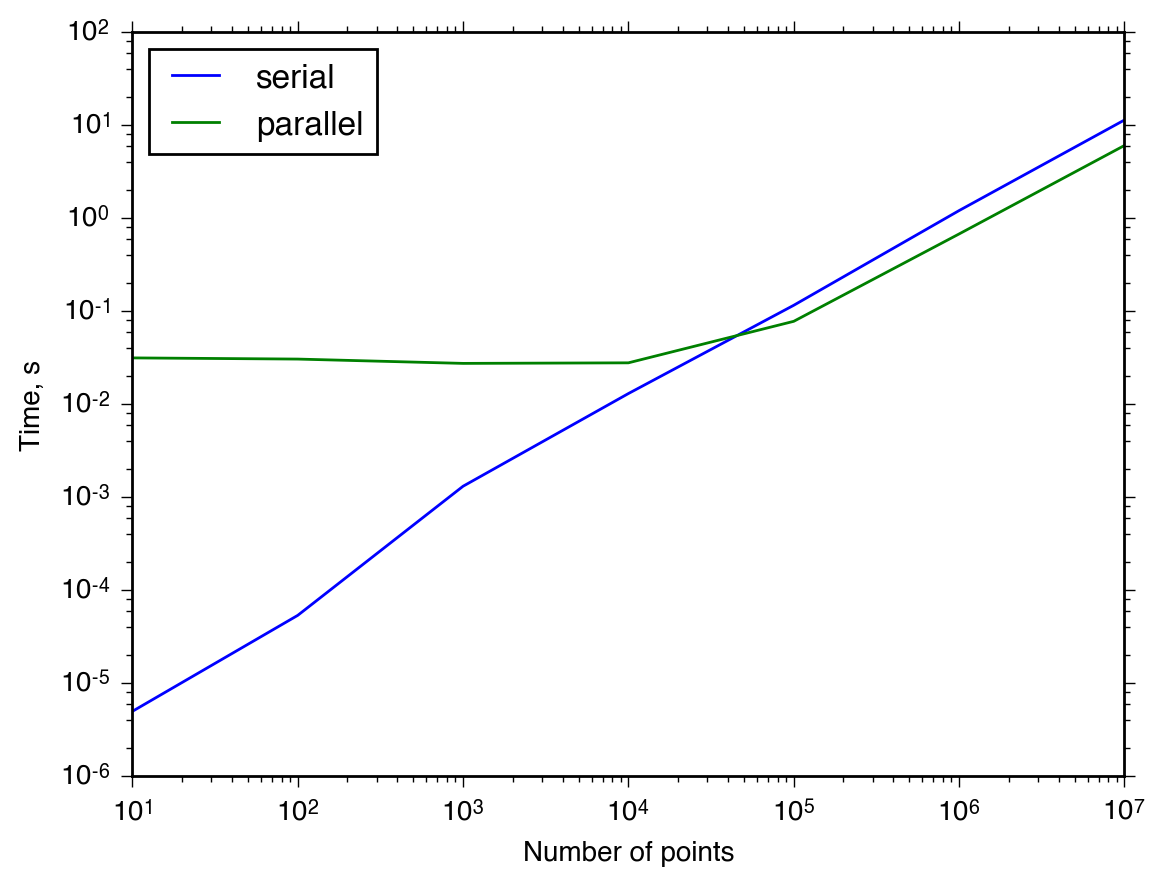

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from time import time

def serial(x):
    return [i**10 for i in x]

@dv.parallel(block=True)
def parallel(x):
    return [i**10 for i in x]

n = [10**i for i in range(1, 8)]

st = []
pt = []
sy = None
py = None
t0 = None

print(('----------------------------------------------------------\n'
       '|   n   | serial time | parallel time | ratio | equality |\n'
       '----------------------------------------------------------'))

for i in n:
    # serial computation
    t0 = time()
    sy = serial(range(i))
    st += [time() - t0]
    
    # parallel blocking computation
    t0 = time()
    py = parallel(range(i))
    pt += [time() - t0]
    
    print('| {:.0e} | {:9.5f} s | {:11.5f} s | {:4.2f}x | {:^8} |'.format(
        i, st[-1], pt[-1], st[-1] / pt[-1], str(sy == py)))
    
print('------------------------------------------------------------')

plt.loglog(n, st, label='serial')
plt.loglog(n, pt, label='parallel')
plt.legend(loc=0)

plt.xlabel('Number of points')
plt.ylabel('Time, s');

**Note** that the serial computation is faster than the parallel
one for `n<1e4`, but when `n>=1e5` we start to see a speed up which
approaches 2x.

## Non-Blocking

------------------------------------------------------------
|   n   | serial time | parallel time |  ratio  | equality |
------------------------------------------------------------
| 1e+01 |   0.00001 s |     0.01231 s |   0.00x |  False   |
| 1e+02 |   0.00019 s |     0.01103 s |   0.02x |  False   |
| 1e+03 |   0.00214 s |     0.01498 s |   0.14x |  False   |
| 1e+04 |   0.01453 s |     0.01138 s |   1.28x |  False   |
| 1e+05 |   0.12084 s |     0.01783 s |   6.78x |  False   |
| 1e+06 |   1.29411 s |     0.14309 s |   9.04x |  False   |
| 1e+07 |  13.11118 s |     0.90541 s |  14.48x |  False   |
------------------------------------------------------------


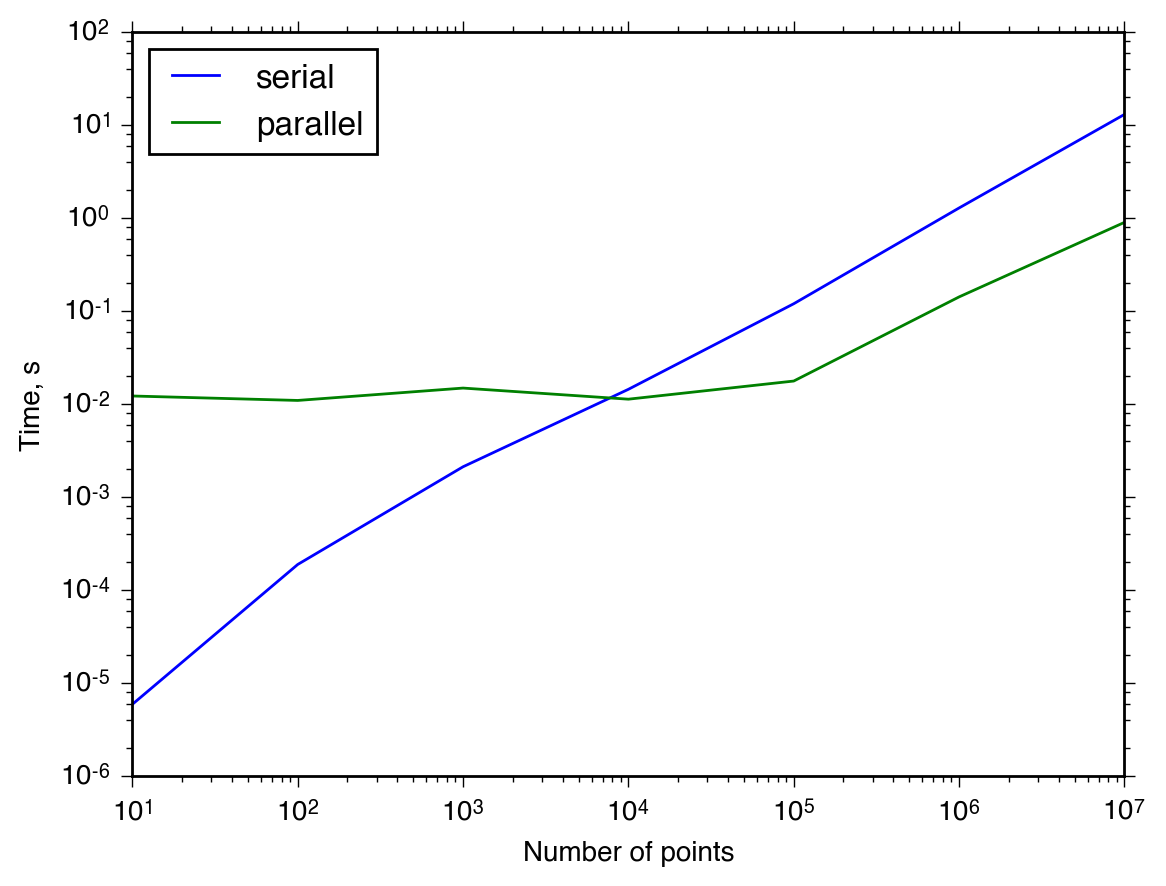

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from time import time

def serial(x):
    return [i**10 for i in x]

@dv.parallel(block=False)  # <------- this line has changed
def parallel(x):
    return [i**10 for i in x]

n = [10**i for i in range(1, 8)]

st = []
pt = []
sy = None
py = None
t0 = None

print(('------------------------------------------------------------\n'
       '|   n   | serial time | parallel time |  ratio  | equality |\n'
       '------------------------------------------------------------'))

for i in n:
    # serial computation
    t0 = time()
    sy = serial(range(i))
    st += [time() - t0]
    
    # parallel blocking computation
    t0 = time()
    py = parallel(range(i))
    pt += [time() - t0]
    
    print('| {:.0e} | {:9.5f} s | {:11.5f} s | {:6.2f}x | {:^8} |'.format(
        i, st[-1], pt[-1], st[-1] / pt[-1], str(sy == py)))
    
print('------------------------------------------------------------')

plt.loglog(n, st, label='serial')
plt.loglog(n, pt, label='parallel')
plt.legend(loc=0)

plt.xlabel('Number of points')
plt.ylabel('Time, s');

Now we get over **10x** increase in performance.

When **non-blocking** calls are made an `AsyncResult` object is
immediately returned. The `AsyncResult` object gives you a way of
getting a result at a later time through its `get()` method.

**Note** that now equality is `False` when comparing the `sy`
result with the `py` result because `py` is now an `AsyncResult`
object. To actually recontruct the result we need to `get()` it.

In [4]:
sy = serial(range(1000))
py = parallel(range(1000))
y = py.get()  # <--- py.get() reconstructs the result
sy == y

True

In [5]:
# setting the direct veiw to be 'blocking' again
dv.block = True

## Parallel list comprehensions
The **`parallel`** decorator above makes the function defined after it
a parallel function to run on multiple cores (engines). It is also possible
to do simple partitioning of elements in a list (or any sequence) and to
run each partition on a separate engine. This is done using `scatter()`
and `gather()`.

At this point it is also reasonable to introduce the `%px` line magic,
which **p**arallel e**x**ecutes a single line on all engines.

A simple `%px` example which executes `print('Hi!')` on all engines.

In [6]:
%px print('Hi!')

[stdout:0] Hi!
[stdout:1] Hi!
[stdout:2] Hi!
[stdout:3] Hi!
[stdout:4] Hi!
[stdout:5] Hi!
[stdout:6] Hi!
[stdout:7] Hi!


The `scatter()` and `gather()` functions distribute variables to the
engines as engines do not have access to the `namespace` of the controller.

This is why

In [7]:
n = 10
%px n**2

CompositeError: one or more exceptions from call to method: execute
[0:execute]: NameError: name 'n' is not defined
[1:execute]: NameError: name 'n' is not defined
[2:execute]: NameError: name 'n' is not defined
[3:execute]: NameError: name 'n' is not defined
.... 4 more exceptions ...

will fail. We never defined `n` on the engines.

They (`scatter()` and `gather()`) do it in a what partitions the sequence
to the number of engines and collects them back.

Exmaple:

In [8]:
dv.scatter('a', range(10))
dv.get('a')

[[0, 1], [2, 3], [4], [5], [6], [7], [8], [9]]

In [9]:
dv.gather('a')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Note that `scatter()` splits `a` up into 8 pieces (we started 8 engines).
the first two engines got a 2-element piece and the rest of the engines
got 1-element pieces.

When `a` is reconstructed with `gather` it is intact and in the right
order.

We can do simple stuff with list comprehensions like so:

In [10]:
n = 8
random_array = np.random.randint(1, 10, (n, n))
dv.scatter('x', random_array)

dv.get('x')

[array([[6, 6, 1, 4, 6, 7, 6, 6]]),
 array([[6, 4, 4, 8, 8, 4, 4, 7]]),
 array([[7, 5, 9, 3, 7, 5, 1, 4]]),
 array([[6, 5, 8, 5, 5, 6, 8, 9]]),
 array([[5, 7, 1, 4, 2, 7, 6, 4]]),
 array([[3, 5, 6, 8, 8, 1, 9, 5]]),
 array([[7, 8, 3, 6, 2, 6, 8, 4]]),
 array([[9, 7, 3, 9, 2, 5, 5, 9]])]

each engine has a different slice of `random_array`. Here the controller
`pulls` the variable `'x'` from each engine.

We could also have the controller ask each engine to print `'x'`:

In [11]:
%px print x

[stdout:0] [[6 6 1 4 6 7 6 6]]
[stdout:1] [[6 4 4 8 8 4 4 7]]
[stdout:2] [[7 5 9 3 7 5 1 4]]
[stdout:3] [[6 5 8 5 5 6 8 9]]
[stdout:4] [[5 7 1 4 2 7 6 4]]
[stdout:5] [[3 5 6 8 8 1 9 5]]
[stdout:6] [[7 8 3 6 2 6 8 4]]
[stdout:7] [[9 7 3 9 2 5 5 9]]


or pull `'x'` from a specified engine:

In [12]:
dv.pull('x', targets=0)

array([[6, 6, 1, 4, 6, 7, 6, 6]])

Now that each engine has a slice of the array, we can distribute
code to be performed on that slice and collect the results.

In [13]:
%px y = x**2

y = dv.gather('y')
print y

[[36 36  1 16 36 49 36 36]
 [36 16 16 64 64 16 16 49]
 [49 25 81  9 49 25  1 16]
 [36 25 64 25 25 36 64 81]
 [25 49  1 16  4 49 36 16]
 [ 9 25 36 64 64  1 81 25]
 [49 64  9 36  4 36 64 16]
 [81 49  9 81  4 25 25 81]]


# Imports - local and remote

By **local** I mean on the controller and by **remote** I mean on the
engines (remember: `ipcluster` starts a controller and `n` engines).

Code that gets distributed to the engines must have access to the
packages it depends on. Engines do not have the same `namespace` as
the controller.

In [14]:
@dv.parallel(block=True)
def parallel_sqrt(x):
    return np.sqrt(x)

parallel_sqrt(range(10))

CompositeError: one or more exceptions from call to method: parallel_sqrt
[0:apply]: NameError: global name 'np' is not defined
[1:apply]: NameError: global name 'np' is not defined
[2:apply]: NameError: global name 'np' is not defined
[3:apply]: NameError: global name 'np' is not defined
.... 4 more exceptions ...

```python
NameError: global name 'np' is not defined
```
is what you get...

There are several ways of dealing with this:

1.. Move all your imports into the parallel function:

In [15]:
@dv.parallel(block=True)
def parallel_sqrt(x):
    import numpy as np  # <--- import on each engine
    return np.sqrt(x)

parallel_sqrt(range(10))

array([ 0.        ,  1.        ,  1.41421356,  1.73205081,  2.        ,
        2.23606798,  2.44948974,  2.64575131,  2.82842712,  3.        ])

This is very cumbersome in my opinion and might create some unnecessary
overhead as all imports are redone every time the function is called.

2.. Synchronize imports everywhere (controller and engines):

In [16]:
with dv.sync_imports():
    import numpy
    
@dv.parallel(block=True)
def parallel_sqrt(x):
    return numpy.sqrt(x)

parallel_sqrt(range(10))

importing numpy on engine(s)


array([ 0.        ,  1.        ,  1.41421356,  1.73205081,  2.        ,
        2.23606798,  2.44948974,  2.64575131,  2.82842712,  3.        ])

**Note** that the usual renaming of the import handle in the same
line like in
```python
import numpy as np
```

does not work on the remote engines, the `as np` is ignored remotely.

3.. and my favorite is to have all your remote imports wrapped around
with the `%%px` cell magic. This **p**arallel e**x**ecutes the imports
on all engines. Note that you still need to do local imports for the
packages you need on the controller.

In [17]:
%%px
import os
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')

In [18]:
# these are local imports ***
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# these are local imports ***

@dv.parallel(block=True)
def parallel_plot_sqrt(x):
    x = np.sqrt(x)
    
    plt.imshow(x, interpolation='nearest', vmin=0, vmax=1)
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    pid = os.getpid()
    plt.gcf().savefig('{}.png'.format(pid), bbox_inches='tight')
    return x, pid

n = 16
result = parallel_plot_sqrt(np.random.rand(n, n))
x = np.vstack(result[::2])
pids = result[1::2]

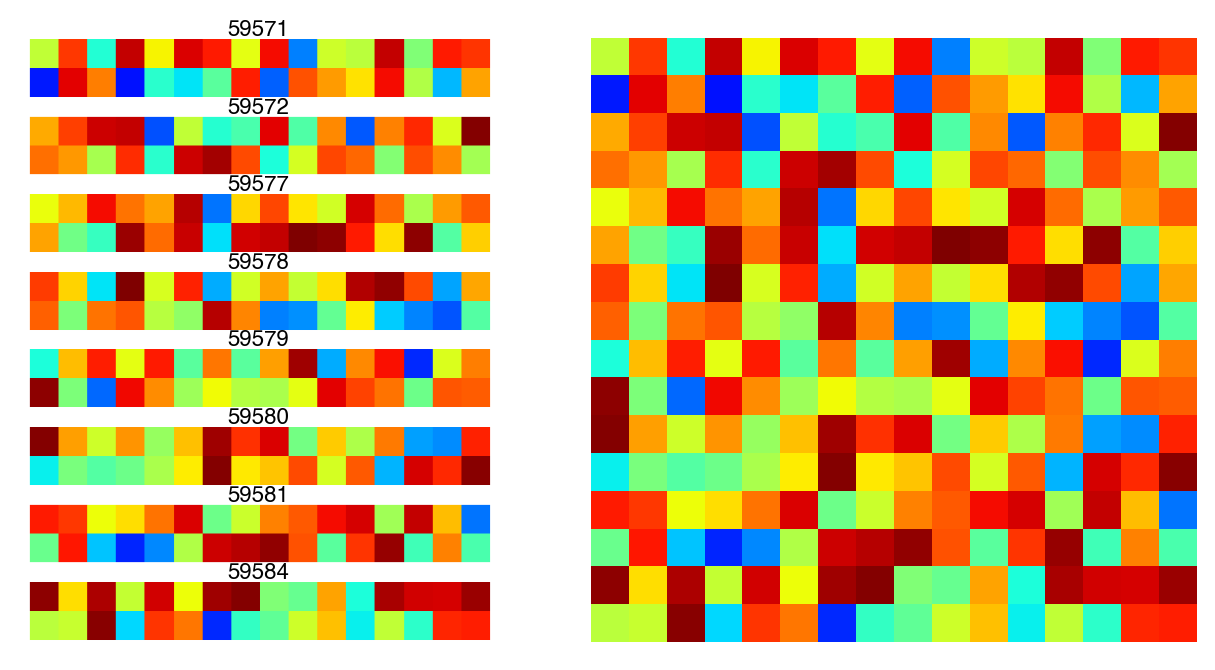

In [19]:
gs = GridSpec(8, 2, wspace=0.05, hspace=0.01)

fig = plt.figure(figsize=(8,4))
ax2 = plt.subplot(gs[:, -1])
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[1, 0])
ax02 = fig.add_subplot(gs[2, 0])
ax03 = fig.add_subplot(gs[3, 0])
ax04 = fig.add_subplot(gs[4, 0])
ax05 = fig.add_subplot(gs[5, 0])
ax06 = fig.add_subplot(gs[6, 0])
ax07 = fig.add_subplot(gs[7, 0])

axi = (ax00, ax01, ax02, ax03, ax04, ax05, ax06, ax07)
for i, pid in enumerate(pids):
    axi[i].imshow(plt.imread('{}.png'.format(pid)))
    axi[i].set_frame_on(False)
    axi[i].set_xticks([])
    axi[i].set_yticks([])
    
    axi[i].set_title(str(pid), fontsize=8, y=0.75)

ax2.imshow(x, interpolation='nearest', vmin=0, vmax=1)
ax2.set_frame_on(False)
ax2.set_xticks([])
ax2.set_yticks([]);

# Time vs. Number of engines

This tutorial would not be complete without looking at performance as a
function of number of cores or engines. For this I used **Ameland**,
the login node of the geophysics group cluster at TU Delft.

I computed the square of 1e7 (10 million) element array on 1, 2, 3, ...,
40 cores.

This is the code I ran in an interactive IPython session:

```python
In [1]: from ipyparallel import Client as RC
        rc = RC()
        ids = rc.ids
        

In [2]: from time import time
        pt = []
        for id in ids:
            dv = rc[:id + 1]
            @dv.parallel(block=True)
            def parallel(x):
                return [i**10 for i in x]
            t0 = time()
            py = parallel(range(int(1e7)))
            pt += [time() - t0]
```
 
 and I plotted the results with this code:
 
 ```python
 In [3]: plt.plot(np.array(ids) + 1, pt)
         plt.xlabel('Number of engines')
         plt.ylabel('Time, s')
```

and here are the results:

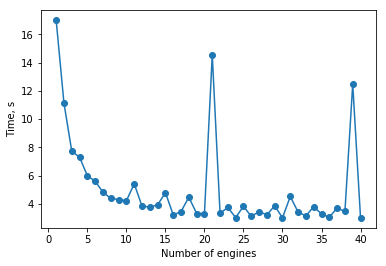

In [22]:
from IPython.display import Image
Image(filename="result.png", embed=True)

Performance quickly improves from about 17 seconds on one engine to
about 4 seconds on 15 engines. The fluctuations in performance probably
originate when the array gets divided up in an odd way. For instance:

`1e7 / 21 = 476190.4761904762`

or

`1e7 / 39 = 256410.2564102564`

In [20]:
[(i, 1e7 / i) for i in range(1, 41)]

[(1, 10000000.0),
 (2, 5000000.0),
 (3, 3333333.3333333335),
 (4, 2500000.0),
 (5, 2000000.0),
 (6, 1666666.6666666667),
 (7, 1428571.4285714286),
 (8, 1250000.0),
 (9, 1111111.111111111),
 (10, 1000000.0),
 (11, 909090.9090909091),
 (12, 833333.3333333334),
 (13, 769230.7692307692),
 (14, 714285.7142857143),
 (15, 666666.6666666666),
 (16, 625000.0),
 (17, 588235.2941176471),
 (18, 555555.5555555555),
 (19, 526315.7894736842),
 (20, 500000.0),
 (21, 476190.4761904762),
 (22, 454545.45454545453),
 (23, 434782.60869565216),
 (24, 416666.6666666667),
 (25, 400000.0),
 (26, 384615.3846153846),
 (27, 370370.3703703704),
 (28, 357142.85714285716),
 (29, 344827.5862068966),
 (30, 333333.3333333333),
 (31, 322580.6451612903),
 (32, 312500.0),
 (33, 303030.30303030304),
 (34, 294117.64705882355),
 (35, 285714.28571428574),
 (36, 277777.77777777775),
 (37, 270270.2702702703),
 (38, 263157.8947368421),
 (39, 256410.2564102564),
 (40, 250000.0)]